<a href="https://colab.research.google.com/github/ludawg44/jigsawlabs/blob/master/03May20_Missing_Values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Missing Values

### Introduction

It's now to moving onto coercing our data.  Let's start with handling our missing values. While we have seen our two step technique of replacing our isna column with the mean, and adding an `isna` column, one of the trickier things is finding missing values that are not listed as na.  In this lesson, we'll work through handling missing values on a large dataset.

In [0]:
import pandas as pd
pd.set_option('display.max_rows',100)

Let's load our training data.

In [0]:
df_listings = pd.read_csv('X_train.csv')

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,16,17,20,28,33,34,49,60,64,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df_listings.shape

(18037, 95)

### Look for additional na values

Oftentimes, we can have missing values that are stored as other values.  For example, we may have values that are stored as -999 or positive 999.  Our values may be stored as empty strings.  

Pandas provides us with a `df.replace` function that allows us to perform find and replace across a dataframe.  

In [0]:
def columns_with_value(df, value):
    listings_with_val = (df == value).any(axis = 0)
    return df[listings_with_val[listings_with_val == True].index]

In [0]:
(columns_with_value(df_listings, 0) == 0).sum()

host_listings_count             15
host_total_listings_count       15
bathrooms                       31
bedrooms                      1194
beds                            26
square_feet                    105
availability_30              11590
availability_60              10025
availability_90               9339
availability_365              8579
number_of_reviews             3114
dtype: int64

Some of these values may be real zero values.  But others perhaps are not.  
* Host listings seems odd.  
* No bathrooms, no bedrooms or beds seems suspicious, but there could be a reason for.  
* The square feet is wrong.
* And the availability scores seem like too many to be accurate.  

So let's plot the columns we have questions with.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133a72e90>,
      dtype=object)

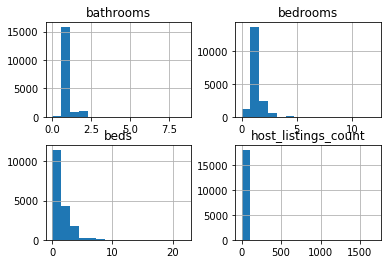

In [0]:
suspicious_cols = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds']
df_listings[suspicious_cols].hist(bins = 15)

Well these numbers don't exactly come off as outliers, so let's keep them.  This leaves the `square_feet` and availability columns as the columns with missing values.

Let's initialize our mapper, and replace the zero values as missing in those columns.

In [0]:
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
import numpy as np

replace_zero_cols = ['availability_30', 'availability_60', 'availability_90']

mapper = DataFrameMapper([
    (['availability_30'], SimpleImputer(missing_values = 0, 
                                      strategy = 'constant',
                                      fill_value = np.nan)),
    (['availability_60'], SimpleImputer(missing_values = 0, 
                                      strategy = 'constant',
                                      fill_value = np.nan)),
    (['availability_90'], SimpleImputer(missing_values = 0, 
                                      strategy = 'constant',
                                      fill_value = np.nan)),
    (['maximum_nights'], SimpleImputer(missing_values = 999, 
                                      strategy = 'constant',
                                      fill_value = np.nan))
], df_out = True)

In [0]:
X_replace_zeros = mapper.fit_transform(df_listings)
X_replace_zeros[:2]

,availability_30,availability_60,availability_90,maximum_nights
0,4,16,30,365
1,30,60,90,1125


Let's see if there are any of our other candidates:

In [0]:
potential_missing_vals = [-999, 999, ' '] 
missing_dfs = [columns_with_value(df, value) for value in potential_missing_vals]
    

In [0]:
[df.columns for df in missing_dfs]

[Index([], dtype='object'),
 Index(['maximum_nights'], dtype='object'),
 Index(['host_about'], dtype='object')]

In [0]:
(df_listings['maximum_nights'] == 999).sum()

7

### Find outliers 

Sometimes our missing value numbers are not stored as numbers that we can predict.  Instead, we may discover them as outliers in our dataset.

Now, with a smaller dataset, we can use pandas to plot histograms of all of our numeric features.  But when we get to more than a dozen or so numeric features, there are some more efficient ways to explore outliers.

In [0]:
from scipy import stats

column = df['availability_30']
stats.zscore(column)

array([-0.56978888, -0.56978888, -0.56978888, ..., -0.22405533,
       -0.56978888,  1.73510146])

In [0]:
from scipy import stats

def percentiles(column):
    z_scores = stats.zscore(column)
    # segment based on number of standard deviations away from the mean     
    hist, bin_edges = np.histogram(z_scores, bins=np.arange(-3, 4, 1), density=True)
    return np.stack((hist, bin_edges[1:]))

In [0]:
z_scores = stats.zscore(df['availability_30'])

In [0]:
import scipy.stats as stats
def percent_outliers(column, sd = 2):
    z_scores = stats.zscore(column)
    percent_outliers = z_scores[np.absolute(z_scores) > sd].shape[0]/z_scores.shape[0]
    return percent_outliers 

In [0]:
percent_outliers(df['availability_30'])

0.08695459382759844

In [0]:
def too_many_outliers(df, sd = 2, threshold = .05):
    return [(col, percent_outliers(df[col])) for col in df.select_dtypes(include=['float64', 'int64']).columns if percent_outliers(df[col]) > threshold]

In [0]:
too_many_outliers(df)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


[('host_id', 0.06784320681092586),
 ('accommodates', 0.052589570769776516),
 ('availability_30', 0.08695459382759844),
 ('availability_60', 0.08043632493792124),
 ('availability_90', 0.07338595246541327),
 ('availability_365', 0.08526959914863427)]

This seems to have worked well.  It identified columns whose values we were already suspicious of with the availability column.  Let's take a look at the accommodates column, even though it's a borderline case.

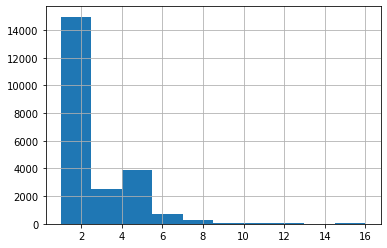

In [0]:
df['accommodates'].hist()

In [0]:
df['accommodates'].describe()

count    22552.000000
mean         2.637460
std          1.510548
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: accommodates, dtype: float64

The values here make sense so we'll leave it alone.

### Resources

[detecting missing values](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

[detecting outliers](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)